[*********************100%%**********************]  12 of 12 completed
[*********************100%%**********************]  12 of 12 completed
[*********************100%%**********************]  12 of 12 completed
[*********************100%%**********************]  12 of 12 completed
[*********************100%%**********************]  12 of 12 completed
[*********************100%%**********************]  12 of 12 completed
[*********************100%%**********************]  12 of 12 completed
[*********************100%%**********************]  12 of 12 completed
[*********************100%%**********************]  12 of 12 completed
[*********************100%%**********************]  12 of 12 completed
[*********************100%%**********************]  12 of 12 completed
[*********************100%%**********************]  12 of 12 completed

Normality Test Results:

AAPL:
- Shapiro-Wilk Test: Statistic=0.989, p-value=0.058
- Anderson-Darling Test: Statistic=0.326, Critical Values=[0.567

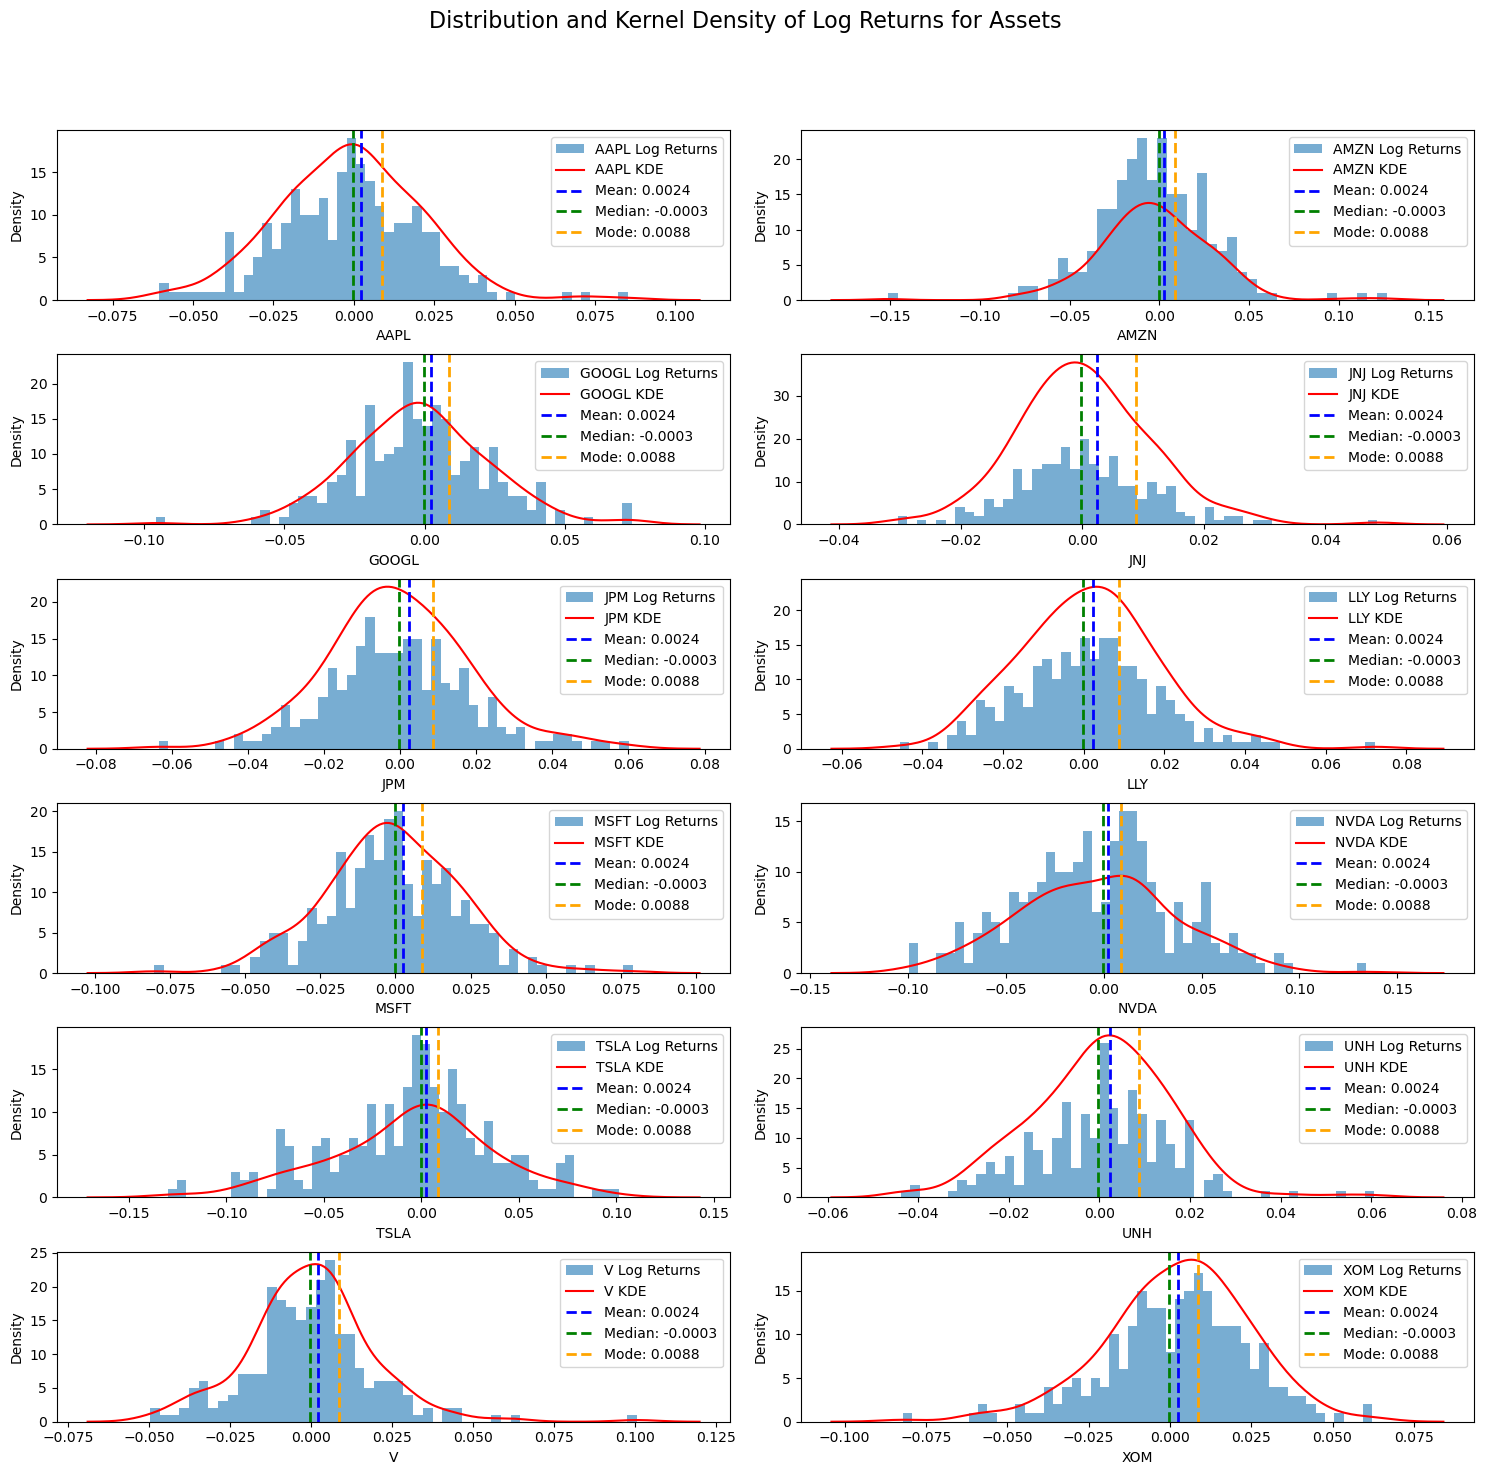

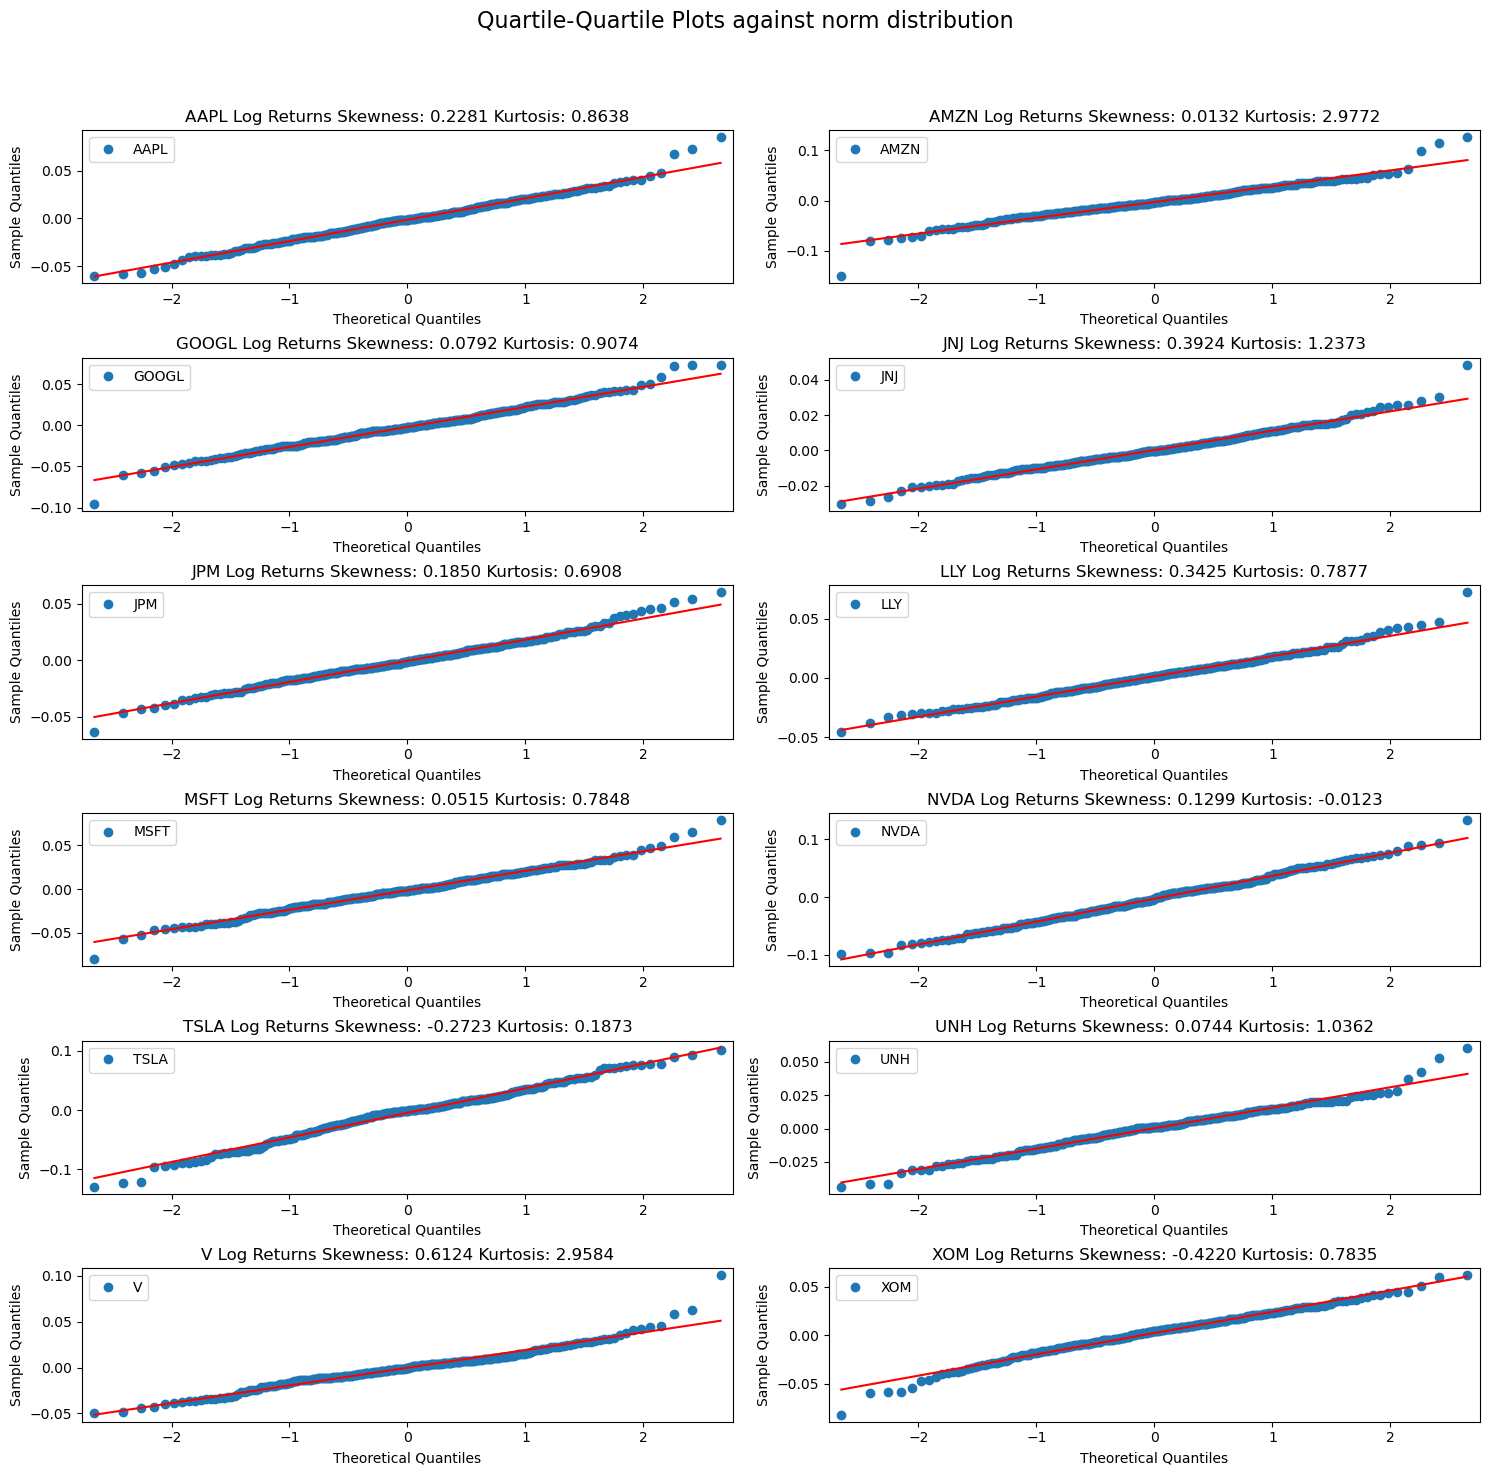

In [56]:
## IMPORT LIBRARIES

import pandas as pd
import numpy as np
import yfinance as yf
from scipy import stats
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns



## DEFINE FUNCTIONS

def fetch_historical_data(assets, start_date, end_date):
    """
    Fetch historical stock price data from Yahoo Finance.

    Parameters:
    - assets (list): List of stock tickers.
    - start_date (str): Start date for data retrieval in "YYYY-MM-DD" format.
    - end_date (str): End date for data retrieval in "YYYY-MM-DD" format.

    Returns:
    - pd.DataFrame: Historical stock price data.
    """
    if len(assets) == 1:
        # Wrap the Series in a DataFrame for consistency:
        data = pd.DataFrame(yf.download(assets, start=start_date, end=end_date)['Adj Close'])
    else:
        data = yf.download(assets, start=start_date, end=end_date)['Adj Close']
    return data


def calculate_returns(data, use_log_returns=False):
    """
    Calculate percentage- or log returns from historical stock price data.

    Parameters:
    - data (pd.DataFrame): Historical stock price data.
    - use_log_returns (bool): If True, calculate log returns; otherwise, calculate percentage returns.

    Returns:
    - pd.DataFrame: Returns data.
    """
    if use_log_returns:
        # Create an empty DataFrame to store the log returns:
        log_returns = pd.DataFrame()
        # Iterate over each column (asset) in the `data` DataFrame:
        for column in data.columns:
            # Shift the values in that column down by one position:
            log_ret = np.log(data[column] / data[column].shift(1))
            # Assign log returns to the corresponding column in `log_returns`.
            log_returns[column] = log_ret
        return log_returns
    else:
        # Calculate regular percentage returns
        returns = data.pct_change().dropna()
        return returns

    
def perform_normality_tests(data):
    """
    Perform normality tests on stock returns data.

    Parameters:
    - data (pd.DataFrame): Returns data.

    Returns:
    - list: Results of normality tests for each asset.
    """
    results = {}

    for asset in data.columns:

        # Shapiro-Wilk Test
        stat_sw, p_value_sw = shapiro(data[asset].dropna())
        
        # Anderson-Darling Test
        result_ad = stats.anderson(data[asset].dropna(), dist='norm')
        stat_ad = result_ad.statistic
        critical_values_ad = result_ad.critical_values
        p_value_ad = result_ad.significance_level

        # Kolmogorov-Smirnov Test
        stat_ks, p_value_ks = stats.kstest(data[asset].dropna(), 'norm')

        results[asset] = {
            'Shapiro-Wilk Test': {'Statistic': stat_sw, 'p-value': p_value_sw},
            'Anderson-Darling Test': {'Statistic': stat_ad, 'Critical Values': critical_values_ad, 'p-value': p_value_ad},
            'Kolmogorov-Smirnov Test': {'Statistic': stat_ks, 'p-value': p_value_ks}
        }
        
    print("\nNormality Test Results:")
    for asset, result in results.items():
        print(f"\n{asset}:")
        print(f"- Shapiro-Wilk Test: Statistic={result['Shapiro-Wilk Test']['Statistic']:.3f}, p-value={result['Shapiro-Wilk Test']['p-value']:.3f}")
        print(f"- Anderson-Darling Test: Statistic={result['Anderson-Darling Test']['Statistic']:.3f}, Critical Values={result['Anderson-Darling Test']['Critical Values']}, p-value={result['Anderson-Darling Test']['p-value']}")
        print(f"- Kolmogorov-Smirnov Test: Statistic={result['Kolmogorov-Smirnov Test']['Statistic']:.3f}, p-value={result['Kolmogorov-Smirnov Test']['p-value']:.3f}")
    
    return[results]
    
    
def plot_histograms_and_kde(data, use_log_returns=False):
    """
    Plot histograms and kernel density plots for stock returns data.

    Parameters:
    - data (pd.DataFrame): Returns data.
    - use_log_returns (bool): If True, use log returns for plotting.

    Returns:
    - None
    """
    # Display histograms and Kernel Density plots in a grid of subplots:
    n_assets = len(data.columns) if isinstance(data, pd.DataFrame) else 1
    n_rows = n_assets // 2 + n_assets % 2

    fig, axes = plt.subplots(n_rows, 2, figsize=(15, 2.5 * n_rows))
    returns_type = "Log Returns" if use_log_returns else "Returns"
    fig.suptitle(f"Distribution and Kernel Density of {returns_type} for Assets", fontsize=16)

    # List to store the axes for each asset
    asset_axes = []

    if isinstance(data, pd.DataFrame):
        for i, asset in enumerate(data.columns):
            row, col = i // 2, i % 2
            ax = axes[row, col]
            asset_axes.append(ax)

            # Plot Histogram:
            ax.hist(data[asset].dropna(), bins=50, alpha=0.6, label=f'{asset} {returns_type}')

            # Plot Kernel Density:
            sns.kdeplot(data[asset].dropna(), ax=ax, label=f'{asset} KDE', color='red')

            # Calculate Mean and Mode using histogram bins:
            mean = np.mean(data[asset].dropna())
            hist, bin_edges = np.histogram(data[asset].dropna(), bins=50)  # Adjust bins as needed
            bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            mode_bin = bin_centers[np.argmax(hist)]  # Bin with the highest count is considered the mode
            median = np.median(data.dropna())


    else:  # For a single series
        ax = axes[0, 0]
        asset_axes.append(ax)

        # Plot Histogram:
        ax.hist(data.dropna(), bins=50, alpha=0.6, label=f'{returns_type}')

        # Plot Kernel Density:
        sns.kdeplot(data.dropna(), ax=ax, label=f'Density', color='red')

        # Calculate Mean and Median and Mode using histogram bins:
        mean = np.mean(data.dropna())
        hist, bin_edges = np.histogram(data.dropna(), bins=50)  # Adjust bins as needed
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        mode_bin = bin_centers[np.argmax(hist)]  # Bin with the highest count is considered the mode
        median = np.median(data.dropna())
        
        ax.set_title(f"{returns_type} Distribution")

    # Plot vertical lines for mean, median, and mode for each asset
    for i, ax in enumerate(asset_axes):
        ax.axvline(mean, color='blue', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.4f}')
        ax.axvline(median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median:.4f}')
        ax.axvline(mode_bin, color='orange', linestyle='dashed', linewidth=2, label=f'Mode: {mode_bin:.4f}')
        ax.legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    
def plot_qq_plot(data, asset, distribution_name="norm", use_log_returns=False):
    """
    Plot a Q-Q plot for the given data against a theoretical distribution.

    :param data: Observed data
    :type data: pandas.Series or numpy.ndarray
    :param asset: Asset name
    :type asset: str
    :param distribution_name: Theoretical distribution name, default is "Normal"
    :type distribution_name: str
    :param use_log_returns: Whether to use log returns, default is False
    :type use_log_returns: bool
    """
    dist = getattr(stats, distribution_name)
    distargs = ()

    # Create subplots for Q-Q plots:
    n_assets = len(data.columns) if isinstance(data, pd.DataFrame) else 1
    n_rows = n_assets // 2 + n_assets % 2
    fig, axes = plt.subplots(n_rows, 2, figsize=(15, 2.5 * n_rows))
    returns_type = "Log Returns" if use_log_returns else "Returns"
    fig.suptitle(f"Quartile-Quartile Plots against {distribution_name} distribution", fontsize=16)
    
    if isinstance(data, pd.DataFrame):
        for i, asset in enumerate(data.columns):
            row, col = i // 2, i % 2
            ax = axes[row, col]
            
            sm.qqplot(data[asset].dropna(), line='s', dist=dist, ax=ax,label=f'{asset}')
        
            # Skewness and Kurtosis
            skewness = stats.skew(data[asset].dropna())
            kurtosis = stats.kurtosis(data[asset].dropna())
            
            ax.set_title(f"{asset} {returns_type} Skewness: {skewness:.4f} Kurtosis: {kurtosis:.4f}")
            ax.legend()
        
    else:  # For a single series
        ax = axes[0, 0]
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    
## CONFIGURE  
    
def configure():
    # Centralise user-configurable settings here: 
    assets = ["AAPL","MSFT", "AMZN", "NVDA", "GOOGL", "TSLA", "UNH", "LLY", "XOM", "JPM", "V", "JNJ"]
    start_date = "2022-01-01"
    end_date = "2023-01-01"
    use_log_returns = True
    distribution_name = "norm"
    return assets, start_date, end_date, use_log_returns, distribution_name


## RUN MAIN

def main():
    
    # Get configuration settings
    assets, start_date, end_date, use_log_returns, distribution_name = configure()    
    
    for asset in assets:
    
        # Fetch historical data for the current year:
        data = fetch_historical_data(assets, start_date, end_date)
        
        # Calculate Returns:
        returns = calculate_returns(data, use_log_returns)
         
    # Perform Normality Tests:
    normality_test_results = perform_normality_tests(returns)
    
    # Plot Histograms and Kernel Density:
    plot_histograms_and_kde(returns, use_log_returns)
    
    # Plot Quantile-Quantile Plot:
    plot_qq_plot(returns, asset, distribution_name, use_log_returns)
    

        
if __name__ == "__main__":
    main()